# QT-Assignment-01

by Guillaume IDAME KORALAGE

## Libraries

Let's import libraries we will need first.

In [1]:
import pandas as pd
import numpy as np

import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

## Functions

Write some functions that we will use in this assignment.

In [2]:
def get_multi_timeseries(list_underlying, period_value, interval_value):
    underlying_data = yf.download(list_underlying, period = period_value, interval = interval_value)
    return underlying_data

def get_timeseries(raw_market_data, parameter): 
    timeseries_data = raw_market_data.xs(parameter, axis = 1)
    return timeseries_data

In [3]:
def get_information_ratio(df, frequency_days): 
    frequency_return = df.pct_change()
    information_ratio = (frequency_return.mean() * frequency_days) / (frequency_return.std() * np.sqrt(frequency_days))
    return information_ratio

## Questions

#### Q1. Read the daily time series of the S&P500 index (since 01-01-1928) with the yfinance library. (Its symbol is "^GSPC".)

In [4]:
period_value = "max"
interval_value = "1d"
list_yahoo_code = ["^GSPC"]
raw_market_data = get_multi_timeseries(list_yahoo_code, period_value, interval_value)

[*********************100%%**********************]  1 of 1 completed


In [5]:
adj_close_price = raw_market_data.xs("Adj Close", axis = 1).to_frame(name = "SPX").loc["1928-01-01":]

In [6]:
adj_close_price

,SPX
Date,
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
1928-01-09,17.500000
...,...
2024-01-18,4780.939941
2024-01-19,4839.810059
2024-01-22,4850.430176


#### Q2. What is the information ratio of being long this index over the entire period. And since 1950? In both cases, based on the formula presented in the lecture, what is the typical timescale below which fluctuations dominates the drift?

If assume $r_f = 0$, the information ratio is the sharpe ratio. We use the function we defined at the start of this notebook now:

In [9]:
information_ratio_entire_period = get_information_ratio(adj_close_price, 252) 
information_ratio_1950 = get_information_ratio(adj_close_price.loc["1950-01-01":], 252) 

print(f'The information ratio of being long SPX over the entire period is {round(information_ratio_entire_period[0],3)}')
print(f'The information ratio of being long SPX since 1950 is {round(information_ratio_1950[0],3)}')

The information ratio of being long SPX over the entire period is 0.404
The information ratio of being long SPX since 1950 is 0.567


The typical timescale below which fluctuations dominate drift is given by $t^*$ such that: $m t^* = \sigma \sqrt{t^*}$

Rearranging we get: $t^* = \frac{\sigma^2}{m^2}$

In our case where $r_f = 0$, $ IR = \frac{m}{\sigma}$

Therefore, $t^* = (\frac{1}{IR})^2$

In [10]:
fluct_entire_period = (1 / information_ratio_entire_period) ** 2
fluct_1950 = (1 / information_ratio_1950) ** 2

print(f'For the entire period, the typical timescale below which fluctuations dominate drift is {round(fluct_entire_period[0],3)} years')
print(f'For period since 1950, the typical timescale below which fluctuations dominate drift is {round(fluct_1950[0],3)} years')

For the entire period, the typical timescale below which fluctuations dominate drift is 6.13 years
For period since 1950, the typical timescale below which fluctuations dominate drift is 3.115 years


#### Q3. Plot the daily log returns as a function of time. What can you say about the volatility of the S&P500 index?

In [11]:
log_return = np.log(adj_close_price / adj_close_price.shift(1)).dropna()

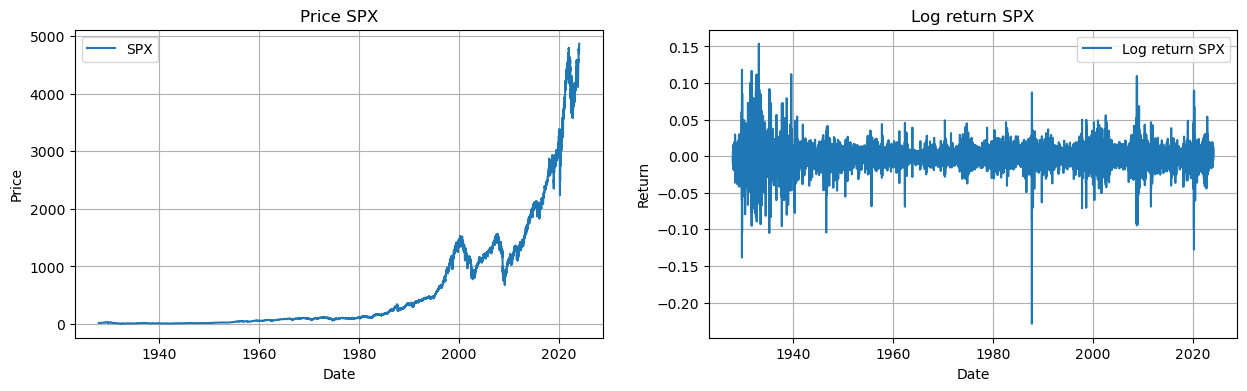

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(adj_close_price, label = "SPX")
ax[0].set_title("Price SPX")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid()
ax[0].legend()

ax[1].plot(log_return, label = "Log return SPX")
ax[1].set_title("Log return SPX")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Return")
ax[1].grid()
ax[1].legend()

In [13]:
volatility_value = log_return.std().to_frame(name = "Volatility (%)") * 100 * np.sqrt(252)
print(volatility_value)

     Volatility (%)
SPX         19.0257


#### Q4. Plot the autocorrelation function of the absolute value of log returns in a log-log scale.

In [14]:
abs_log_return = abs(log_return).squeeze()
autocorr_vector = [abs_log_return.autocorr(lag_value) for lag_value in range(1, 100+1)]

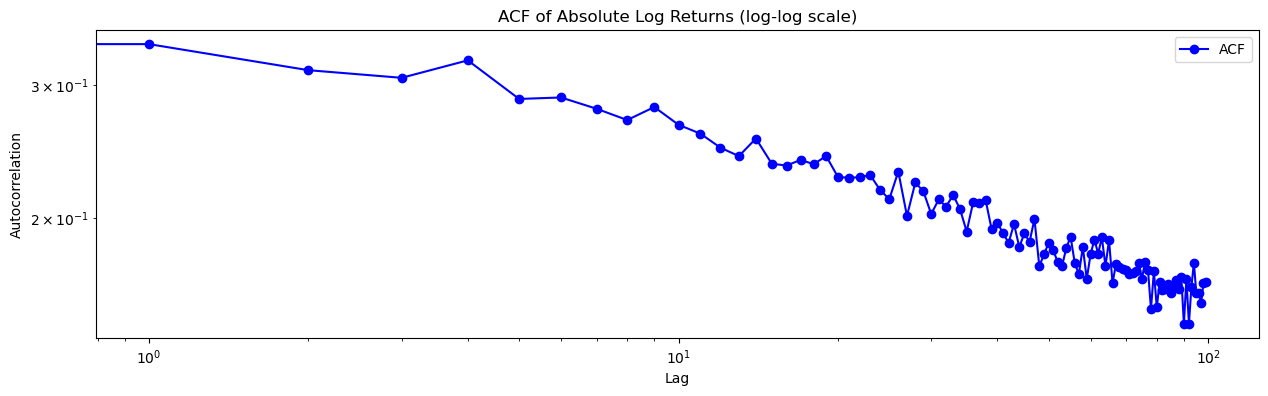

In [15]:
fig, ax  = plt.subplots(figsize = (15, 4))
ax.plot(autocorr_vector,  marker='o', linestyle='-', color='b', label = "ACF")
ax.set_title('ACF of Absolute Log Returns (log-log scale)')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

#### Q5. Fit that data with a power law function $f(T)$ ~ $T^{-v}$ (restricting yourself to the first 100 points). What exponent do you find?

In [16]:
data_power_fit = autocorr_vector[0]+[np.log(y**(-1/27)) for y in range(1, 100 + 1)]

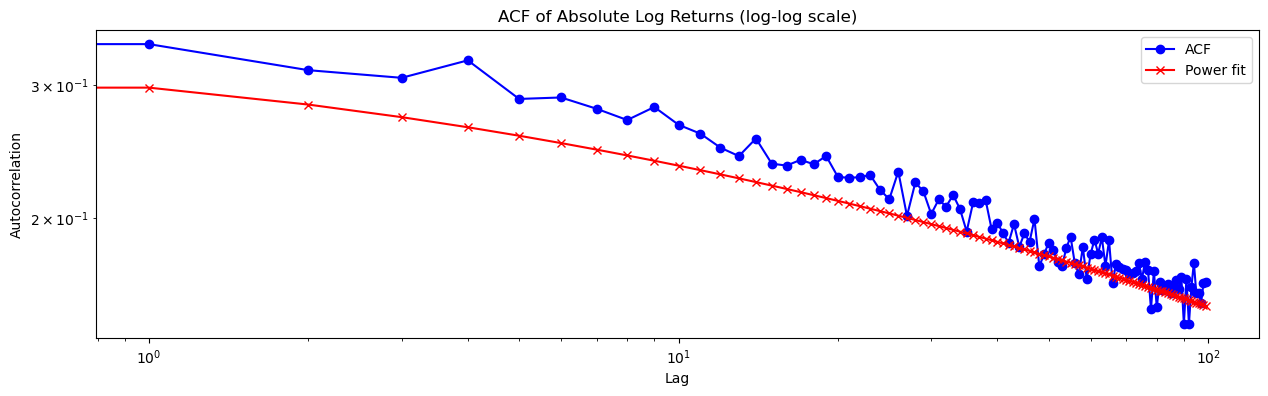

In [17]:
fig, ax  = plt.subplots(figsize = (15, 4))
ax.plot(autocorr_vector,  marker='o', linestyle='-', color='b', label = "ACF")
ax.plot(data_power_fit,  marker='x', linestyle='-', color='r', label = "Power fit")
ax.set_title('ACF of Absolute Log Returns (log-log scale)')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

It looks like an exponent of $-\frac{1}{27}$ fits the data well.

#### Q6. Bonus question: What is your expectation about the drawdown lengths for series with autocorrelated volatility? 

In general, if volatility is positively autocorrelated (i.e., high-volatility periods are likely to be followed by high-volatility periods and low-volatility periods are likely to be followed by low-volatility periods), one might expect longer drawdown periods. This is because high-volatility periods could lead to larger price drops, which would take longer to recover from.

However, this is clearly a simplification. The actual length of drawdowns would also depend on other factors, such as the overall trend of the market (bull or bear), the magnitude of the volatility, and specific events that might cause large price swings.